In [148]:
# !pip install timm
# !pip install grad-cam

In [2]:
import torch
import timm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [3]:
model = timm.create_model("tiny_vit_5m_224", pretrained=True, num_classes=37)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dict = torch.load(
    "tiny_vit_5m_224_2025-01-06_17-38.pth", map_location=device, weights_only=True
)
print("About to load state dict...")
try:
    model.load_state_dict(state_dict)
    print("State dict loaded successfully!")
except Exception as e:
    print(f"Error while loading state dict: {e}")

model = model.to(device)
_ = model.eval()

About to load state dict...
State dict loaded successfully!


In [4]:
image_path = 'american_bulldog_113.jpg'

In [141]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = Image.open(image_path)

In [150]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [149]:
cam = GradCAM(model=model, target_layers=[model.stages[-1].blocks[-1].local_conv])

In [151]:
def apply_gradcam(image):
    input_tensor = transform(image).unsqueeze(0).to(device)
    target_class = int(np.argmax(model(input_tensor).cpu().detach().numpy()))
    targets = [ClassifierOutputTarget(target_class)]
    grayscale_cam = cam(
        input_tensor=input_tensor, targets=targets, aug_smooth=True, eigen_smooth=True
    )

    # Get the first image in the batch
    grayscale_cam = grayscale_cam[0, :]

    # Convert PIL Image to numpy array for visualization
    rgb_img = np.array(image.resize((224, 224))) / 255.0

    # Generate visualization
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    return rgb_img, visualization, target_class

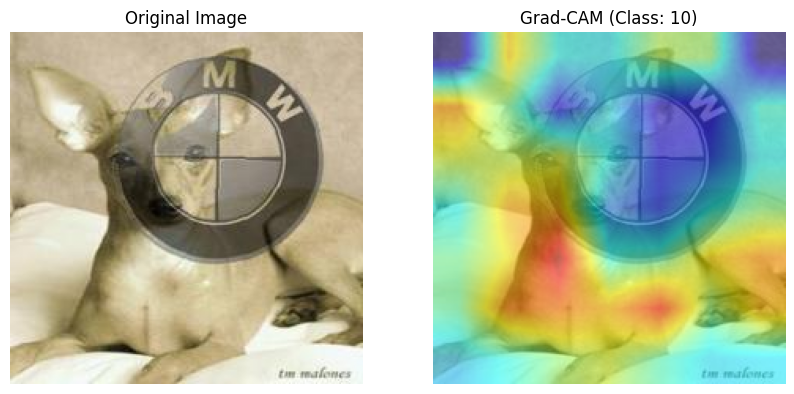

In [152]:
original_img, cam_result, pred_class = apply_gradcam(image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cam_result)
plt.title(f"Grad-CAM (Class: {pred_class})")
plt.axis("off")
plt.show()